Brendon Bottle

Midterm Project Capstone


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score
import pickle
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

# Was getting several future warnings while plotting that were causing issues, supressing those here for easier reading
warnings.simplefilter(action='ignore', category=FutureWarning)

# Setting random state varaible to use throughout code
rs = 7284

# Project Goals and Signifigance

The goal of this project is to identify whether a donor contact will say yes to giving if contacted during the next fundraising campaign. Being able to predict this would improve the ROI for fundraisers by allowing them to prioritize contacts who are likely to say yes and therefore increasing the ratio of gifts to contacts and potentially improving revenue for the organization. 

# Methodology

To achieve this goal I will be developing and testing a number of supervised machine learning models including decision tree, random forest, and XGboost. As a binary classifier, I will look at accuracy, precision, recall, F1 score, and ROC score as measures for the success of the model.

Because the primary goal is to produce a list of donor contacts who are expected to say yes, and knowing that these types of models often prefrom quite well, I expect that I will land on using a Random Forest Classifier to produce this list. However, if the model preformance is not significantly different, a Decision Tree Classifier could be valuable since it is easier to interpret after completion, whereas a random forest is more of a black box model. 

# Data Description

For this project I am using a dataset from Kaggle (source: https://www.kaggle.com/datasets/momohmustapha/donorsprediction?select=Raw_Data_for_train_test.csv) that includes a number of records for donors who were contacted during a previous fundraising campaign. For each donor, there is information on whether they agreed to give during the last campaign, their demographic information (such as gender, age, median home value in their area, etc.), and previous giving history (including lifetime gift amount, maximum gift amount, and minimum gift amount)

One note on this data, according to the description on Kaggle, this dataset was provided by Pairview Limited. Doing some searching I believe that refers to Pairview Training (https://www.pairviewtraining.com/) which provides bootcamp type trainings for technical skills such as data science. My understanding is that this dataset was part of one of their trainings. For my purposes this does mean that there's a decent amount of context missing from the data including information on whether the data is real or generated and what several of the features are supposed to represent. Because of this, I've made some broad assumptions and changed some aspects of the data that I wouldn't have changed in a real world setting in order to make it more workable outside of the training context. 

In [2]:
# Load data file

donors = pd.read_csv('Raw_Data_for_train_test.csv')

In [3]:
donors.shape

(19372, 50)

# Data Preparation

## Removing Columns Missing Context

As mentioned, there were a number of features that I coudn't determine what they represented that I suspect had more context from the training. After testing the model with and without these features and not seeing any difference in the success rates, I determined that my project and presentation would benefit from dropping all the features that I didn't know how to interpret to make it easier to explain my choices on cleaning the data. Even without these features, I still have a significant number of features and a realistic dataset to work from. 

In [4]:
donors.drop(columns= ['TARGET_D', 'OVERLAY_SOURCE', 'PCT_ATTRIBUTE1', 'PCT_ATTRIBUTE2', 'PCT_ATTRIBUTE3', 'PCT_ATTRIBUTE4', 'PEP_STAR', 'RECENT_STAR_STATUS', 'RECENCY_STATUS_96NK', 'FREQUENCY_STATUS_97NK', 
                      'IN_HOUSE', 'RECENT_CARD_RESPONSE_PROP', 'RECENT_AVG_CARD_GIFT_AMT', 'RECENT_CARD_RESPONSE_COUNT', 'LIFETIME_CARD_PROM', 'CARD_PROM_12', 'FILE_CARD_GIFT', 'SES', 'CLUSTER_CODE'], 
                      inplace=True)

In [5]:
donors.columns.shape

(31,)

### Unclear Columns

There were also 2 features that I believe I understood what they represented, but I wasn't clear on whether they were relevant for the goal of my project

#### CONTROL_NUMBER Column

The desciription of this column indicates that it's some form of donor identification number, but it's not clear if it provides any particular value beyond just an index. Checking the number of unique values against the total observations, it appears that each row is a unique donor ID and so I can drop it in favor of the index.

In [6]:
# Check if there are duplicate donor IDs 
donors.CONTROL_NUMBER.nunique() == len(donors)

True

In [7]:
donors.drop(columns= 'CONTROL_NUMBER', inplace=True)

#### FILE_AVG_GIFT

The description of this column just stated that it's the "average gift from raw data" but doesn't explain what that raw data is or what its relation to the other AVG_GIFT features is. Looking at the number of observations where the columns match, it appears that this is just a duplicate of the LIFETIME_AVG_GIFT_AMT column, so I will just drop the FILE feature from the dataset. 

In [8]:
# Check how many observations have a match between FILE and the other AVG_GIFT columns

print(len(donors[donors.RECENT_AVG_GIFT_AMT == donors.FILE_AVG_GIFT]) == len(donors))

print(len(donors[donors.LIFETIME_AVG_GIFT_AMT == donors.FILE_AVG_GIFT]) == len(donors))


False
True


In [9]:
donors.drop(columns='FILE_AVG_GIFT', inplace= True)

In [10]:
# Check details of final DF

donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19372 entries, 0 to 19371
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TARGET_B                     19372 non-null  int64  
 1   MONTHS_SINCE_ORIGIN          19372 non-null  int64  
 2   DONOR_AGE                    14577 non-null  float64
 3   URBANICITY                   19372 non-null  object 
 4   HOME_OWNER                   19372 non-null  object 
 5   DONOR_GENDER                 19372 non-null  object 
 6   INCOME_GROUP                 14980 non-null  float64
 7   PUBLISHED_PHONE              19372 non-null  int64  
 8   MOR_HIT_RATE                 19372 non-null  int64  
 9   WEALTH_RATING                10562 non-null  float64
 10  MEDIAN_HOME_VALUE            19372 non-null  int64  
 11  MEDIAN_HOUSEHOLD_INCOME      19372 non-null  int64  
 12  PCT_OWNER_OCCUPIED           19372 non-null  int64  
 13  PER_CAPITA_INCOM

## Missing Values

Now that I have pared the dataset down to just the columns that I want to consider for this project, I can begin working on cleaning the remaining data. As a first step, I want to look at missing values in the data to see where I might need to drop features or impute values. 

Looking at the data description, I can see that several of the categorical columns have been coded with values such as "?" when the data was not known. So to get the full list of missing values, I'll need to look at both null values and these coded values

In [11]:
# Check for columns with missing values

donors.isnull().sum()[donors.isnull().sum() > 0]

DONOR_AGE                      4795
INCOME_GROUP                   4392
WEALTH_RATING                  8810
MONTHS_SINCE_LAST_PROM_RESP     246
dtype: int64

In [12]:
# Check for columns with values coded as missing, but not recorded an null

for col in donors.columns:
    if donors[col].dtype == 'object':
        print(f'{col}:\n', donors[col].unique(), '\n')

URBANICITY:
 ['?' 'R' 'S' 'U' 'C' 'T'] 

HOME_OWNER:
 ['H' 'U'] 

DONOR_GENDER:
 ['M' 'F' 'U' 'A'] 



In [13]:
# Count total number of coded null values

temp_dict = {'URBANICITY': ['?'], 'HOME_OWNER': ['U'], 'DONOR_GENDER': ['U', 'A']}

print('Number of Missing Values')
for key in temp_dict.keys():
    print(key, ": ", len(donors[donors[key].isin(temp_dict[key])]))

Number of Missing Values
URBANICITY :  454
HOME_OWNER :  8766
DONOR_GENDER :  1018


### WEALTH_RATING and HOME_OWNER

WEALTH_RATING and HOME_OWNER are both missing from about half the observations. HOME_OWNER is also odd because the only two values are H indicating they are a homeowner or U for unknown, but there are no values indicating they are a renter. Without a clear way to impute these values, and the signficant number of missing values, I will just drop these features from the dataset.

In [14]:
donors.drop(columns=['WEALTH_RATING', 'HOME_OWNER'], inplace= True)


### URBANICITY

URBANICITY has about 2% of the data coded as unknown. Because this is such a small portion, I am just going to replace these with the most common category, 'S'

In [15]:
# Chceck stats of URBANICITY missing values

print('Number of missing values in URBANICITY: ', len(donors[donors['URBANICITY'] == '?']))
print('Percent of missing values in URBANICITY: ', round((len(donors[donors['URBANICITY'] == '?'])/len(donors))*100, 2), '%')
print('Most Common Category in URBANICITY: ', donors['URBANICITY'].describe().top)

Number of missing values in URBANICITY:  454
Percent of missing values in URBANICITY:  2.34 %
Most Common Category in URBANICITY:  S


In [16]:
donors['URBANICITY'] = donors['URBANICITY'].apply( lambda u: 'S' if u == '?' else u)

donors['URBANICITY'].unique()

array(['S', 'R', 'U', 'C', 'T'], dtype=object)

### DONOR_AGE

When looking at DONOR_AGE, I found one oddity in that there are 2 newborns who have made donations, and when looking at the data before dropping HOME_OWNER, one showed as owning a home. This seems highly unlikely, so I would assume these are instances where the gift was made on behalf of someone else and that the demographics are about the donor not the child, but it's not clear whether the giving history is related to the child or the person who made the gift. 

Looking at the details there appear to be 200 minors, or about 1% of the total donors. Because it's not clear that the information for those donors is accurate, I will just drop these records to focus only on adult donors. 

In [17]:
donors.DONOR_AGE.describe()

count    14577.000000
mean        58.919051
std         16.669382
min          0.000000
25%         47.000000
50%         60.000000
75%         73.000000
max         87.000000
Name: DONOR_AGE, dtype: float64

In [18]:
donors[donors['DONOR_AGE'] == 0]

,TARGET_B,MONTHS_SINCE_ORIGIN,DONOR_AGE,URBANICITY,DONOR_GENDER,INCOME_GROUP,PUBLISHED_PHONE,MOR_HIT_RATE,MEDIAN_HOME_VALUE,MEDIAN_HOUSEHOLD_INCOME,...,LIFETIME_GIFT_AMOUNT,LIFETIME_GIFT_COUNT,LIFETIME_AVG_GIFT_AMT,LIFETIME_GIFT_RANGE,LIFETIME_MAX_GIFT_AMT,LIFETIME_MIN_GIFT_AMT,LAST_GIFT_AMT,NUMBER_PROM_12,MONTHS_SINCE_LAST_GIFT,MONTHS_SINCE_FIRST_GIFT
8967,0,77,0.0,S,M,2.0,1,0,1083,374,...,88.0,8,11.0,13.0,18.0,5.0,14.0,13,21,75
13698,0,137,0.0,C,M,2.0,1,35,705,266,...,264.0,11,24.0,32.0,37.0,5.0,37.0,14,18,127


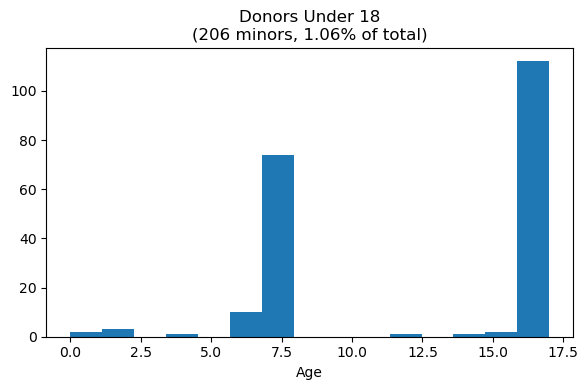

In [19]:
num_minor = donors.DONOR_AGE[donors.DONOR_AGE < 18].count()
pct_minor = round((num_minor/len(donors))*100, 2)

fig, ax = plt.subplots(figsize = (6, 4))

ax.hist(donors['DONOR_AGE'][donors['DONOR_AGE'] < 18], bins= 'sqrt')
ax.set_title(f'Donors Under 18\n({num_minor} minors, {pct_minor}% of total)')
ax.set_xlabel('Age')

fig.tight_layout()
plt.show()

In [20]:
donors = donors[(donors['DONOR_AGE'] >= 18) | (donors['DONOR_AGE'].isnull())]

donors.DONOR_AGE.describe()

count    14371.000000
mean        59.587085
std         15.807695
min         18.000000
25%         47.000000
50%         60.000000
75%         73.000000
max         87.000000
Name: DONOR_AGE, dtype: float64

After dropping the minors, there are still about 25% of the values missing. While it's possible that some of these are also minors, given the distribution of age, it's much more likley they are adults and should remain in the dataset so I will just assume they are not minors. 

Looking at the distribution across the outcome categories, these null age donor contacts don't appear to be significantly different than the overall donor contacts , so I will assume the missing values are relatively random.

However, given that it's 1/4 of the data that's missing, it seems like trying to impute a single value would end up severly skewing the distribution and potentially impacting the results. But, since the distribution is relatively normal, I can maintain the distribution by just assigning a random age from a normal distribution with the same mean and standard deviation. 

In [21]:
null = donors['DONOR_AGE'].isnull().sum()

print(f'There are now {null} rows with missing values or approximately {round(null/len(donors)*100, 2)}% of the total.')

There are now 4795 rows with missing values or approximately 25.02% of the total.


In [22]:
donors[pd.isnull(donors['DONOR_AGE'])]['TARGET_B'].value_counts()

TARGET_B
0    3631
1    1164
Name: count, dtype: int64

Text(0.5, 1.0, 'Distributuion of age of Donors')

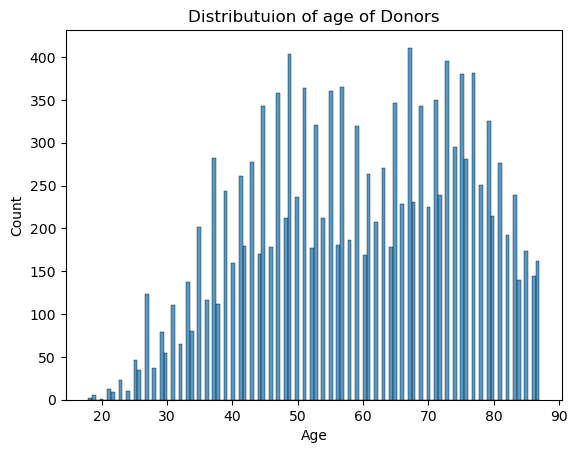

In [23]:
sns.histplot(donors['DONOR_AGE'], bins='sqrt')
plt.xlabel('Age')
plt.title('Distributuion of age of Donors')

In [24]:
# Radnomly assign each null value with a value from a normal distribution
np.random.seed(rs)

func = lambda x: round(np.clip(np.random.normal(loc= donors.DONOR_AGE.mean(), scale= donors.DONOR_AGE.std()), 18, 87)) if pd.isnull(x) else x

donors['DONOR_AGE'] = donors['DONOR_AGE'].apply(func)

donors.DONOR_AGE.describe()

count    19166.000000
mean        59.534906
std         15.634606
min         18.000000
25%         48.000000
50%         60.000000
75%         73.000000
max         87.000000
Name: DONOR_AGE, dtype: float64

### INCOME_GROUP

INCOME_GROUP also has a significant number of values missing, about 22%

Once again, the distributions across the target look very similar to the overall and to the other income groups, indicating these unknown income groups ar relatively random. I attempted to do some checking to see if I could determine whether the Income Group was determined by something like the MEDIAN_HOUSEHOLD_INCOME, but while the average household income did seem to align with the change in group, the min and max salaries didn't seem to have any correlation. So I couldn't determine a way to impute this value based on that. 

Given that there did seem to be some correlation between this feature and the neighborhood affluence features, I decided that the other income related features would be sufficent for testing and chose to drop this feature. 

In [25]:
# Check details of missing values 

print(donors.INCOME_GROUP.describe())

print('\nMissing values: ', donors.INCOME_GROUP.isnull().sum())
print('\nPercent missing values: ', round(donors.INCOME_GROUP.isnull().sum()/len(donors)*100, 2))

count    14811.000000
mean         3.914050
std          1.862701
min          1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: INCOME_GROUP, dtype: float64

Missing values:  4355

Percent missing values:  22.72


In [26]:
# Compare distriubtion across target classes for each group
for g in donors.INCOME_GROUP.unique():
    print(f'\nIncome Group {g}')
    print(donors[donors['INCOME_GROUP'] == g]['TARGET_B'].value_counts())

print('\nNull Income Group')
print(donors[pd.isnull(donors['INCOME_GROUP'])]['TARGET_B'].value_counts())


Income Group 2.0
TARGET_B
0    1962
1     622
Name: count, dtype: int64

Income Group 7.0
TARGET_B
0    1131
1     424
Name: count, dtype: int64

Income Group 5.0
TARGET_B
0    2298
1     807
Name: count, dtype: int64

Income Group 6.0
TARGET_B
0    1153
1     429
Name: count, dtype: int64

Income Group 3.0
TARGET_B
0    1271
1     422
Name: count, dtype: int64

Income Group 1.0
TARGET_B
0    1412
1     370
Name: count, dtype: int64

Income Group 4.0
TARGET_B
0    1871
1     639
Name: count, dtype: int64

Income Group nan
Series([], Name: count, dtype: int64)

Null Income Group
TARGET_B
0    3262
1    1093
Name: count, dtype: int64


In [27]:
# Check mean meadian household income for each group

for inc in donors.INCOME_GROUP.unique():
    print(inc, ":", donors['MEDIAN_HOUSEHOLD_INCOME'][donors.INCOME_GROUP == inc].describe().T['mean'])

2.0 : 272.80611455108357
7.0 : 476.80128617363346
5.0 : 365.2099838969404
6.0 : 450.63400758533504
3.0 : 302.30596574128765
1.0 : 256.89506172839504
4.0 : 336.34980079681276
nan : nan


In [28]:
# Compare min and max median household income for each group

temp_df = pd.DataFrame(columns=['inc_group', 'min_inc', 'max_inc'])

for inc in donors.INCOME_GROUP.unique():
    max = donors['MEDIAN_HOUSEHOLD_INCOME'][donors.INCOME_GROUP == inc].max()
    min = donors['MEDIAN_HOUSEHOLD_INCOME'][donors.INCOME_GROUP == inc].min()
    temp_df.loc[len(temp_df)] = [inc, min, max]

temp_df.sort_index()

,inc_group,min_inc,max_inc
0,2.0,0.0,1040.0
1,7.0,0.0,1500.0
2,5.0,0.0,1500.0
3,6.0,0.0,1500.0
4,3.0,0.0,1036.0
5,1.0,0.0,1287.0
6,4.0,0.0,1386.0
7,NaN,NaN,NaN


In [29]:
# Drop feature

donors.drop(columns='INCOME_GROUP', inplace= True)

### MONTHS_SINCE_LAST_PROM_RESP

This category has a relatively small number of missing values. However, in the review of the data, I noticed that some donors were listed as having negative amounts of time since the last promotion response. I would assume that this is an issue with individuals who may have set up a future or recurring donation indicating that they have a donation logged in the system for a future date, or possibly just a data entry error. Without more context, and given that it's such a small number of observations (8), I'll just drop those from the dataset. 

For the missing values there appears to be a similar feature called MONTHS_SINCE_LAST_GIFT. It appears that PROM_RESP indicates the last time someone gave a gift in response to a promotion, where LAST_GIFT just indicates the last time they gave a gift at all. It appears that in about 86% of cases where I do have data, these numbers are the same, so I will assume that if there is not a record for last promotion response, that it should be the same as the last time they gave a gift and just fill in that value. 

In [30]:
print(donors.MONTHS_SINCE_LAST_PROM_RESP.describe())

print('\nNumber of missing values: ', donors.MONTHS_SINCE_LAST_PROM_RESP.isnull().sum())

count    18923.000000
mean        19.039529
std          3.415648
min        -12.000000
25%         17.000000
50%         18.000000
75%         21.000000
max         36.000000
Name: MONTHS_SINCE_LAST_PROM_RESP, dtype: float64

Number of missing values:  243


In [31]:
# Look at negative month observations

donors[donors['MONTHS_SINCE_LAST_PROM_RESP'] < 0]

,TARGET_B,MONTHS_SINCE_ORIGIN,DONOR_AGE,URBANICITY,DONOR_GENDER,PUBLISHED_PHONE,MOR_HIT_RATE,MEDIAN_HOME_VALUE,MEDIAN_HOUSEHOLD_INCOME,PCT_OWNER_OCCUPIED,...,LIFETIME_GIFT_AMOUNT,LIFETIME_GIFT_COUNT,LIFETIME_AVG_GIFT_AMT,LIFETIME_GIFT_RANGE,LIFETIME_MAX_GIFT_AMT,LIFETIME_MIN_GIFT_AMT,LAST_GIFT_AMT,NUMBER_PROM_12,MONTHS_SINCE_LAST_GIFT,MONTHS_SINCE_FIRST_GIFT
203,0,125,76.0,R,M,1,20,557,186,76,...,97.0,32,3.03,3.0,5.0,2.0,3.0,18,16,122
5214,0,77,45.0,T,M,0,0,381,164,73,...,70.0,4,17.50,25.0,30.0,5.0,30.0,14,18,69
5807,1,89,69.0,R,M,1,1,269,224,81,...,62.0,8,7.75,5.0,10.0,5.0,8.0,14,18,78
6682,0,65,87.0,C,F,1,1,754,341,86,...,90.0,9,10.00,10.0,15.0,5.0,10.0,9,20,64
8343,0,41,55.0,U,F,1,0,0,181,0,...,45.0,8,5.63,5.0,10.0,5.0,5.0,12,18,41
9601,1,125,81.0,T,F,0,0,300,87,37,...,150.0,31,4.84,4.0,7.0,3.0,5.0,11,16,118
10391,0,137,59.0,R,F,1,0,645,288,90,...,162.0,15,10.80,14.0,17.0,3.0,14.0,12,20,116
13456,0,53,51.0,T,F,1,0,854,408,89,...,58.0,5,11.60,10.0,15.0,5.0,15.0,12,17,53


In [32]:
# Drop negative month observations

donors = donors[(donors['MONTHS_SINCE_LAST_PROM_RESP'] >= 0) | (donors['MONTHS_SINCE_LAST_PROM_RESP'].isnull())]

donors.MONTHS_SINCE_LAST_PROM_RESP.describe()

count    18915.000000
mean        19.051864
std          3.363213
min          2.000000
25%         17.000000
50%         18.000000
75%         21.000000
max         36.000000
Name: MONTHS_SINCE_LAST_PROM_RESP, dtype: float64

In [33]:
# Check what percentage of observations have the same value for both last_prom and last_gift

len(donors[donors.MONTHS_SINCE_LAST_PROM_RESP == donors.MONTHS_SINCE_LAST_GIFT])/len(donors)

0.8589101158784842

In [34]:
# Replace missing values with last_gift value

donors.MONTHS_SINCE_LAST_PROM_RESP = donors.apply(lambda x: x['MONTHS_SINCE_LAST_GIFT'] if pd.isnull(x['MONTHS_SINCE_LAST_PROM_RESP']) else x['MONTHS_SINCE_LAST_PROM_RESP'], axis=1)

donors.MONTHS_SINCE_LAST_PROM_RESP.isnull().sum()

0

### DONOR_GENDER

For DONOR_GENDER, about 5% are marked as unknown or A. However I can't find any information about what 'A' represents so I'm going to just treat it as an uknown value. Since this is such a small amount of data, I will just recode this to the most common category, F.

In [35]:
# Check stats of donor gender

print('Reamining values are:', donors['DONOR_GENDER'].unique())

print('Percent with unknown coding is: ', round((len(donors[donors['DONOR_GENDER'].isin(['U', 'A'])])/len(donors))*100, 2), '%')

print('Most common category is: ', donors['DONOR_GENDER'].describe()['top'])


Reamining values are: ['M' 'F' 'U' 'A']
Percent with unknown coding is:  5.27 %
Most common category is:  F


In [36]:
# Replace U and A with F
donors['DONOR_GENDER'] = donors['DONOR_GENDER'].apply(lambda g: 'F' if g in ['U', 'A'] else g)

donors['DONOR_GENDER'].unique()

array(['M', 'F'], dtype=object)

In [37]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19158 entries, 0 to 19371
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TARGET_B                     19158 non-null  int64  
 1   MONTHS_SINCE_ORIGIN          19158 non-null  int64  
 2   DONOR_AGE                    19158 non-null  float64
 3   URBANICITY                   19158 non-null  object 
 4   DONOR_GENDER                 19158 non-null  object 
 5   PUBLISHED_PHONE              19158 non-null  int64  
 6   MOR_HIT_RATE                 19158 non-null  int64  
 7   MEDIAN_HOME_VALUE            19158 non-null  int64  
 8   MEDIAN_HOUSEHOLD_INCOME      19158 non-null  int64  
 9   PCT_OWNER_OCCUPIED           19158 non-null  int64  
 10  PER_CAPITA_INCOME            19158 non-null  int64  
 11  RECENT_RESPONSE_PROP         19158 non-null  float64
 12  RECENT_AVG_GIFT_AMT          19158 non-null  float64
 13  RECENT_RESPONSE_COUNT

## Fix Categories

One adjustment I need to make is updating the type of PUBLISHED_PHONE which is listed as an integer, but is clearly a binary classification object. 

In [38]:
donors['PUBLISHED_PHONE'] = donors['PUBLISHED_PHONE'].astype('object')

# Exploratory Data Analysis

## Target Imbalance

I've noted this in the data clean up before, but to call it out here, the targets are very imbalanced with about 75% of potential donors saying no in the last campaign. This is fairly typical of donor data, but it is something I'll need to look at during the model selection process since tree-models can be tripped up by imbalanced data.

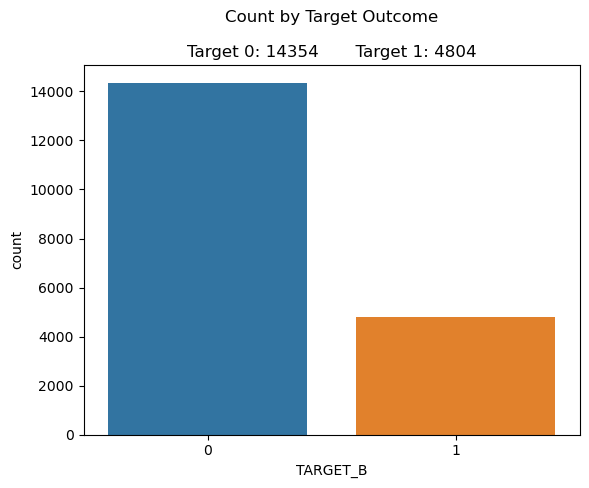

In [39]:
count0 = donors['TARGET_B'].value_counts()[0]
count1 = donors['TARGET_B'].value_counts()[1]
sns.countplot(donors, x = 'TARGET_B')
plt.title(f'Count by Target Outcome\n\nTarget 0: {count0}       Target 1: {count1}')

plt.show()

## Data Grouping

It appears that the features break down into two fairly distinct categories: demographics (such as gender, age, neighborhood median income, etc.) and previous giving statistics (average gift amount, months since last gift, etc.). It will be useful to break these groups out and look at their distribution across the target categories to determine if there are any that appear to be influential. 

To help with the plotting, I've created two functions, one to plot the distribution plots for the numeric values and the other to show the distributions across the target outcomes. For the distribution across target outcomes, I have clipped off any outliers using the IQR method in order to more easily visualize the distributions of the main portion of the data and compare how it looks across targets.

In [40]:
demogs = ['DONOR_AGE', 'URBANICITY', 'DONOR_GENDER', 'PUBLISHED_PHONE', 'MEDIAN_HOME_VALUE', 'MEDIAN_HOUSEHOLD_INCOME', 'PCT_OWNER_OCCUPIED', 'PER_CAPITA_INCOME']

gift_stats = ['MONTHS_SINCE_ORIGIN', 'MOR_HIT_RATE','RECENT_RESPONSE_PROP', 'RECENT_AVG_GIFT_AMT', 'RECENT_RESPONSE_COUNT', 'MONTHS_SINCE_LAST_PROM_RESP', 'LIFETIME_PROM',
       'LIFETIME_GIFT_AMOUNT', 'LIFETIME_GIFT_COUNT', 'LIFETIME_AVG_GIFT_AMT', 'LIFETIME_GIFT_RANGE', 'LIFETIME_MAX_GIFT_AMT', 'LIFETIME_MIN_GIFT_AMT', 'LAST_GIFT_AMT', 'NUMBER_PROM_12', 
       'MONTHS_SINCE_LAST_GIFT', 'MONTHS_SINCE_FIRST_GIFT']

In [41]:
# Functions to make plotting groups easier

def plot_data_numeric(features):
    num_col = donors[features].select_dtypes(include='number').columns

    for col in num_col:
        fig, axs = plt.subplots(ncols = 2, figsize = (12, 4))
        axs[0].hist(donors[col], bins = 'sqrt')
        axs[1].boxplot(donors[col], vert = False)
        fig.suptitle(col)

def plot_data_target(features, axs):
    '''Function takes a list of feature names and an axs object from a pyplot subplots object of any size and plots the features against the target'''

    rav_axs = axs.ravel()

    for idx, col in enumerate(features):
        if donors[col].dtype == 'object':
            sns.countplot(data=donors, hue='TARGET_B', x=col, ax=rav_axs[idx])
            rav_axs[idx].set_title(f'{col}')
            rav_axs[idx].set_xlabel(None)
        else:
            # Outliers were making teh graphs unreadable, so I've dropped them here just for the visualization
            q75, q25 = np.percentile(donors[col], [75 ,25])
            iqr = q75 - q25
            min = q25 - iqr * 1.5
            max = q75 + 1.5 * iqr

            temp_df = donors[(donors[col] >= min) & (donors[col] <= max)]

            sns.boxplot(data=temp_df, x = 'TARGET_B', y= col, ax= rav_axs[idx])
            avg_0 = round(donors[donors['TARGET_B'] == '0'][col].mean(),2)
            avg_1 = round(donors[donors['TARGET_B'] == '1'][col].mean(), 2)
            rav_axs[idx].set_title(f'{col}\n\nAvg 0 = {avg_0}, Avg 1 = {avg_1}')
            rav_axs[idx].set_xlabel(None)

    plt.tight_layout()
    plt.show()

## Demographic Features

### Overall Distribution

Using boxplots and histograms to explore the distribution of the numeric columns a few things jump out. Unsurprisingly, the affluence measures are all very skewed with some donors having very high measures on affluence with the majority being more average. In a couple instances we see potential outliers, espeically with PER_CAPITA_INCOME. Both these things indicate that the data would need some transformation for a method like Logistic Regression to be useful. However, the tree methods are all robust to outliers and don't need normality of data to preform. So it seems like sticking to those will be the best bet for a first pass. 

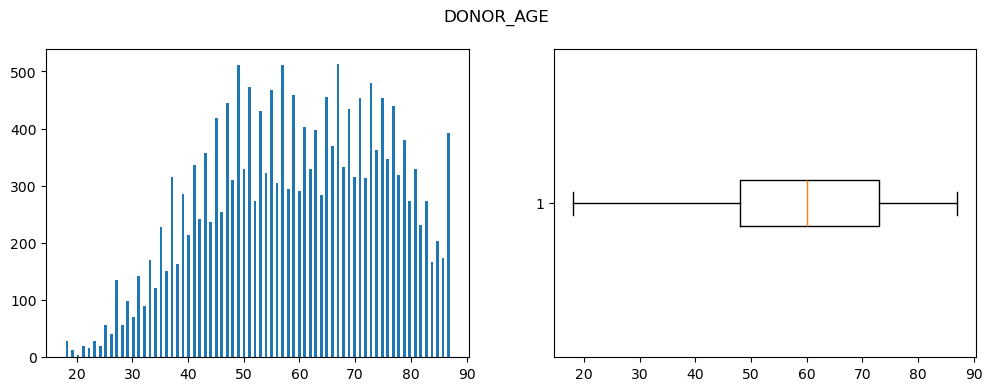

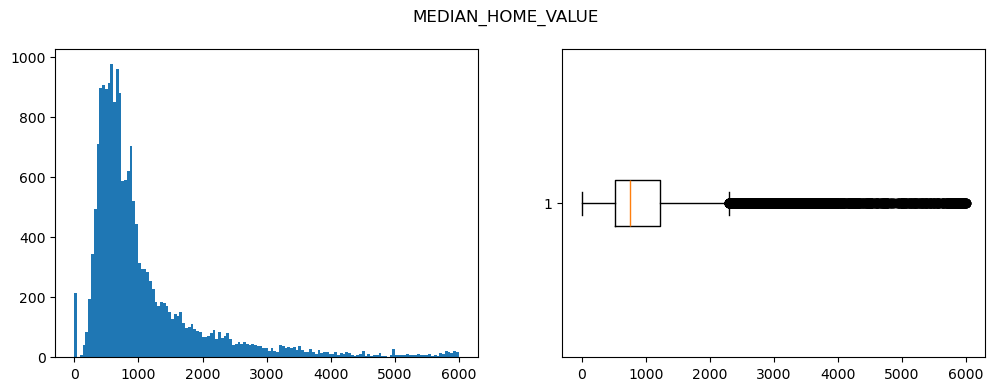

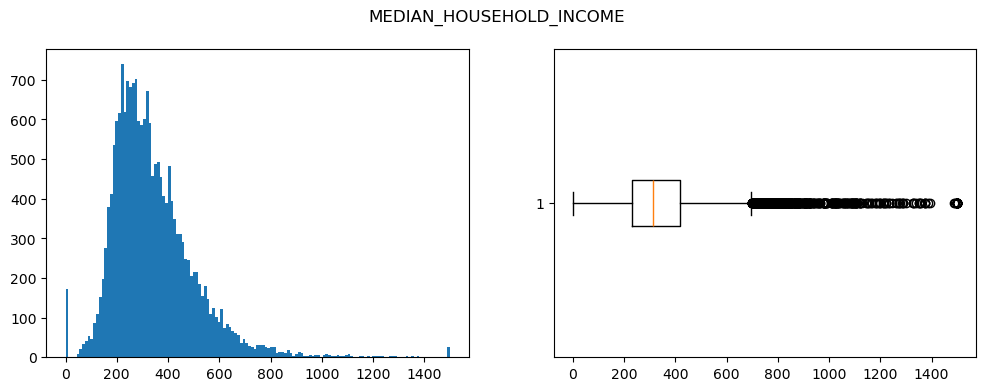

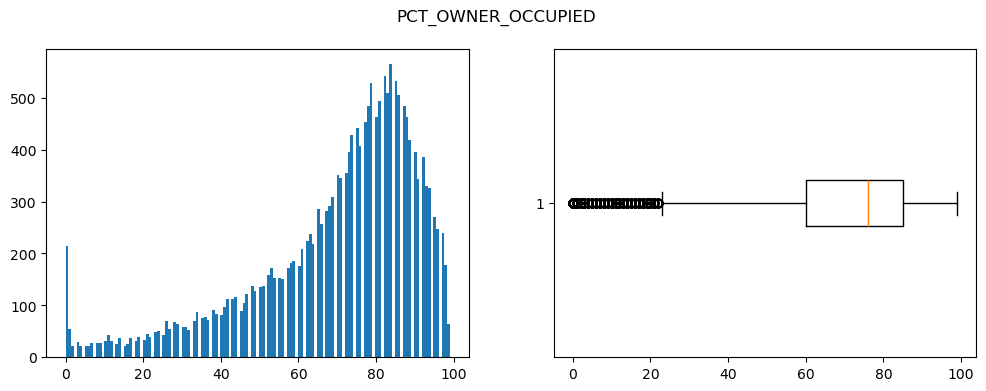

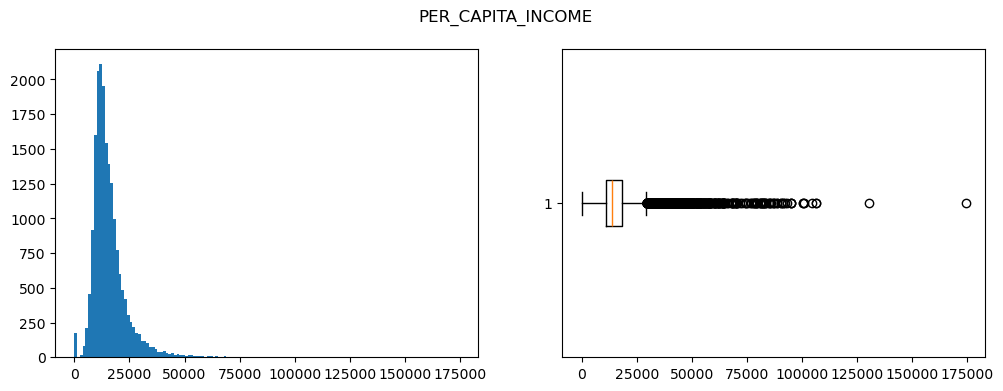

In [42]:
plot_data_numeric(demogs)

### Comparing Target Groups

In order to get a sense of what features I would expect to influence predictions, I'll look at each of the features broken out by target to see how they compare. Here I'm looking for any features where there is a distinct difference in the distribution including spread, average, or median. For these plots, I found it worked best to only plot values that were not outliers according to the IQR method since thsoe outliers were compressing the graphs to the point of being unreadable. I have not removed them from the dataset though, and the averages on the plots include all values.

Looking across these distributions, there doesn't seem to be any major differences between the groups. While on average group 0 appears to be slightly less affluent than group 1, it's not by very much. And for other demographics, there's virutally no difference between the groups. While it's possible there are interactions that make these features more predictive, I don't think using only demographic features will yield much in the way of predictions, so I will also explore giving statistics and use those in the model as well. 

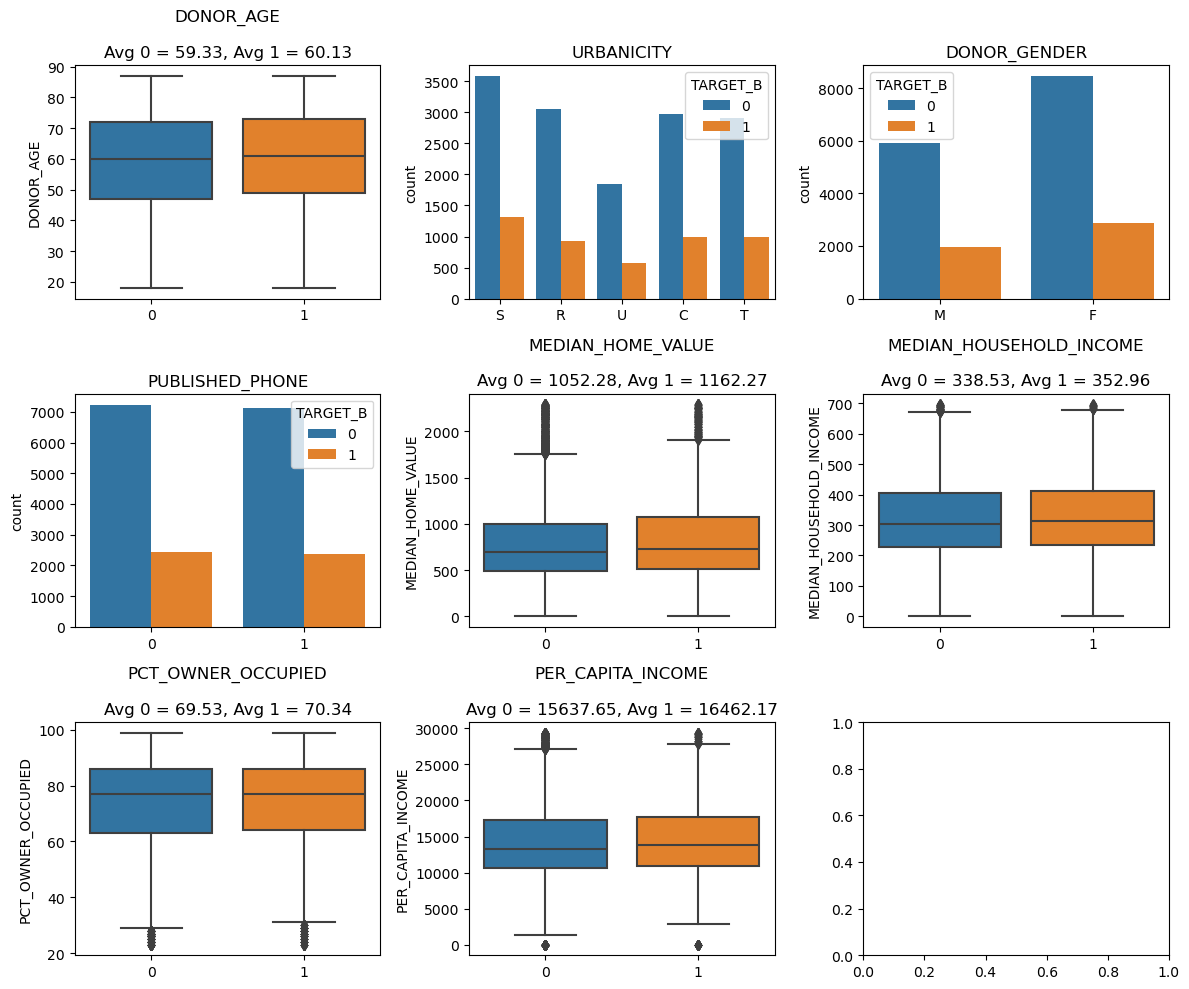

In [43]:
# Plots were not working with the target vairable as a number, switching to string for plotting purposes
donors['TARGET_B'] = donors['TARGET_B'].astype('str')

fig, axs = plt.subplots(3, 3, figsize = (12, 10))

plot_data_target(demogs, axs)

## Giving Statistics

### Overall Distribution

Giving statististics generally appear to have high skew and they almost all have instances of outliers. This isn't surprising since people give in very different ways. In many cases, people are probably giving smaller, regular donations, while others may just give a very large sum one time. Without more background on exactly what donations are recorded (for instance the $1,000 gift could have been part of estate planning) I will assume that these are all valid observations. This is giving further support to sticking with tree models though, since these outliers could be an issue for a regression model. 

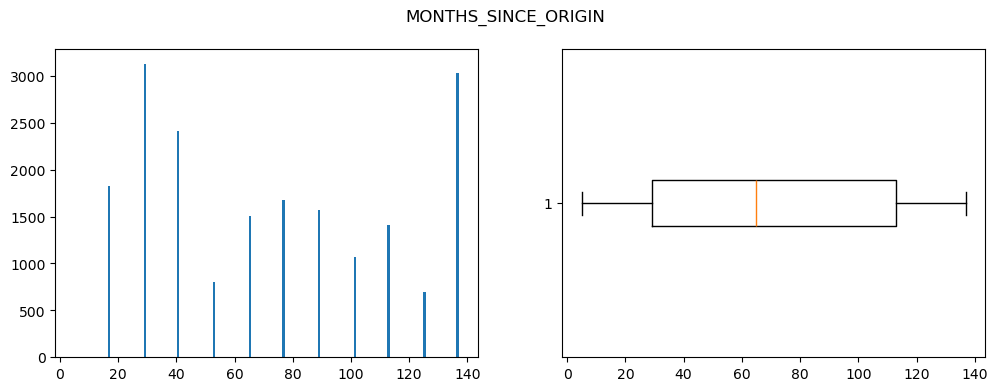

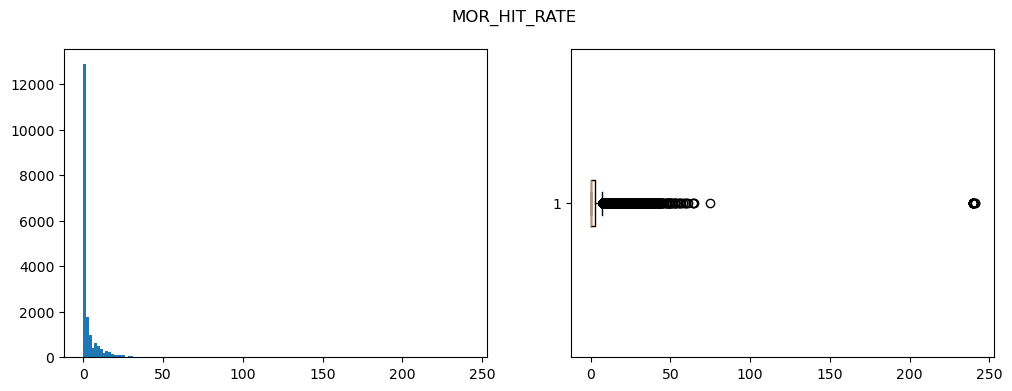

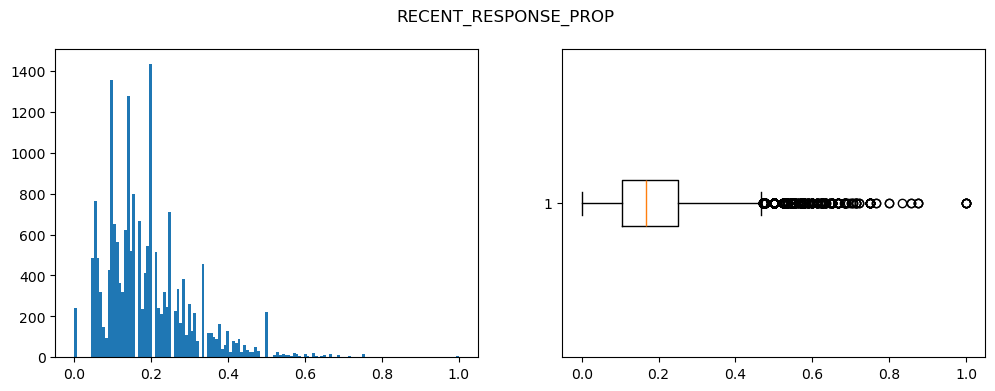

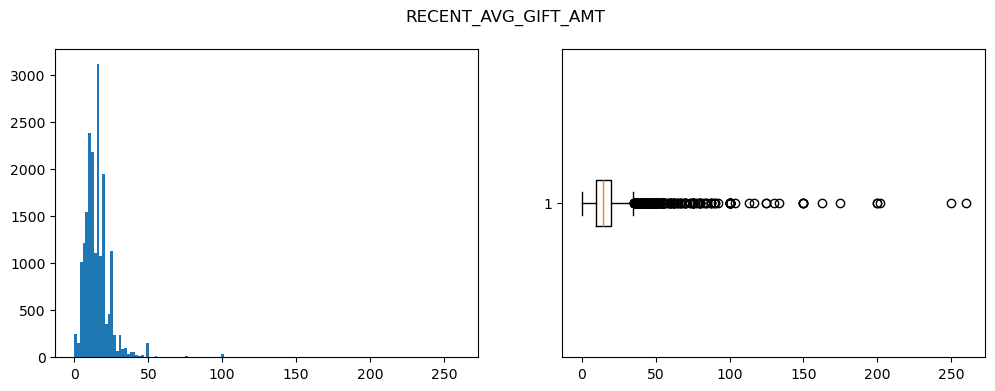

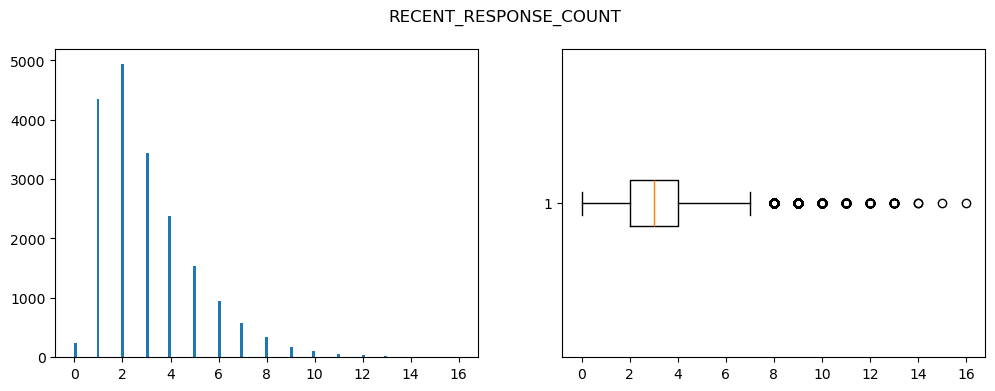

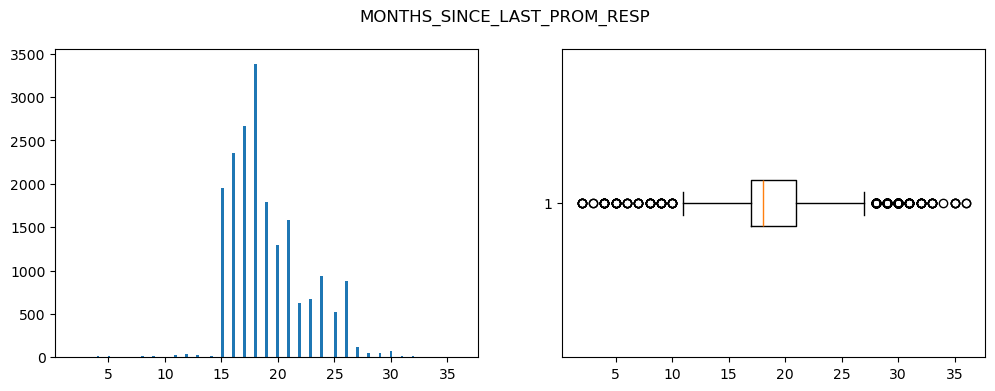

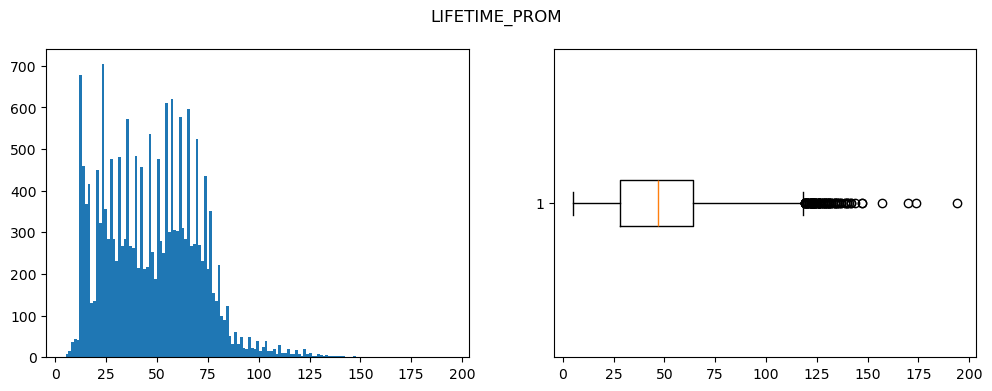

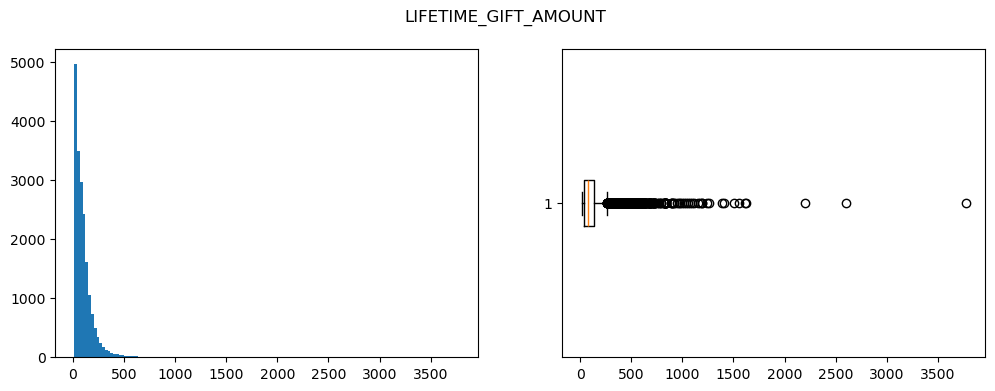

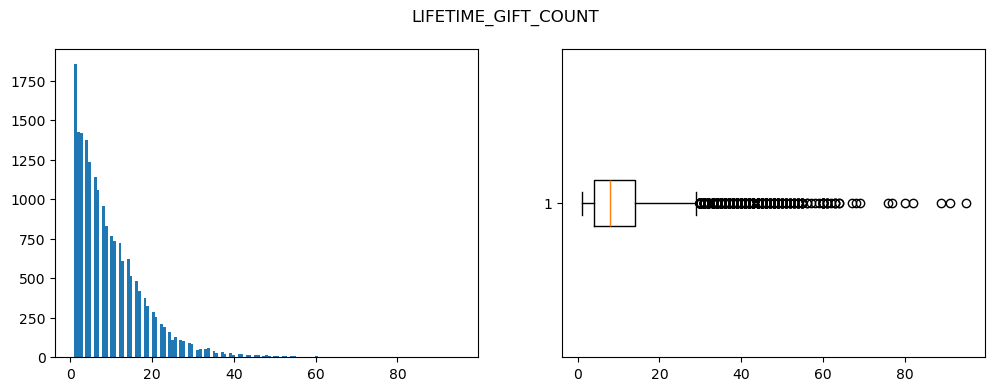

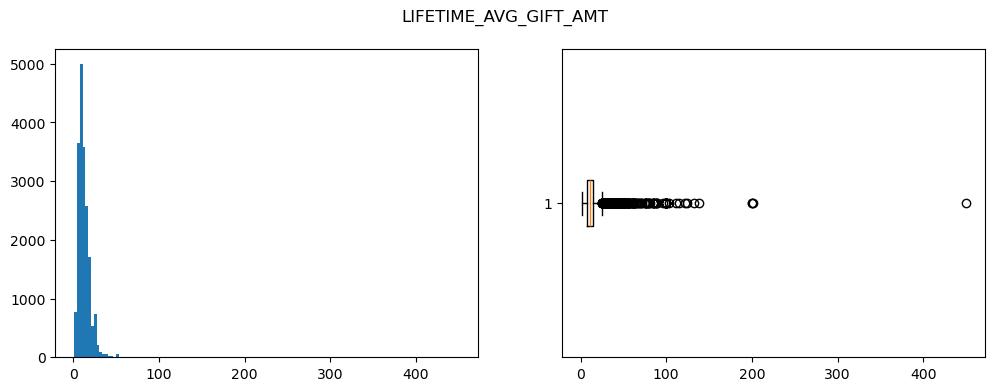

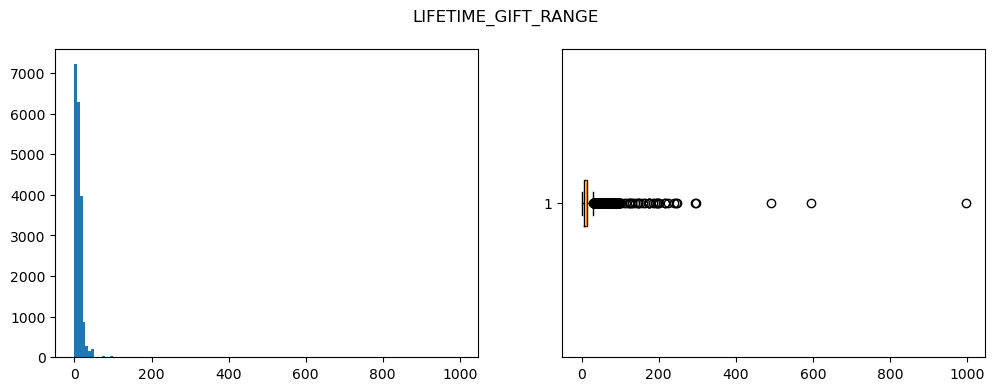

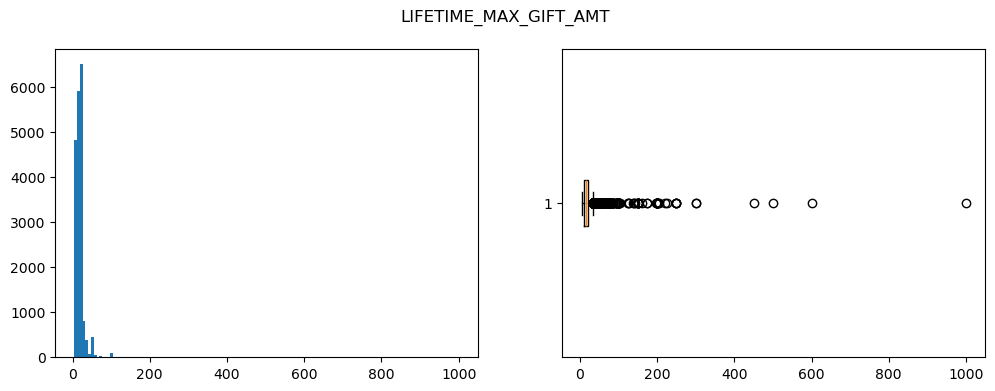

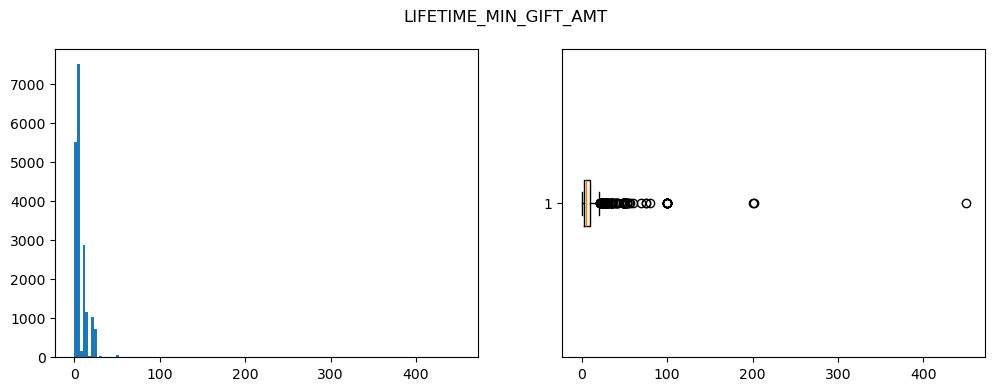

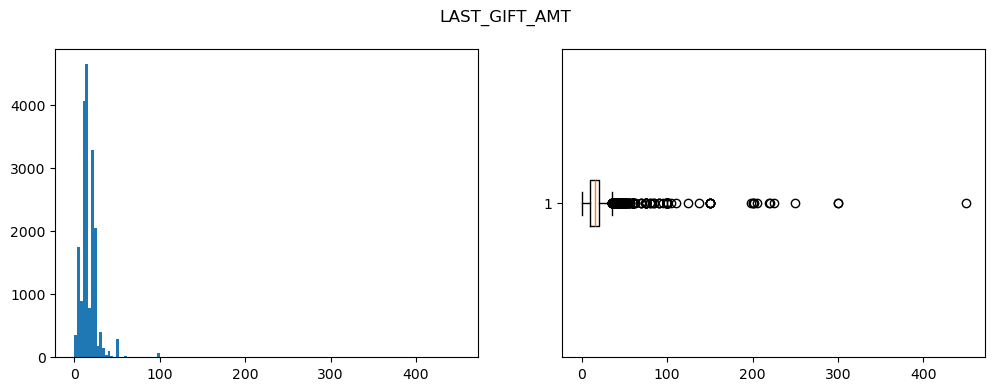

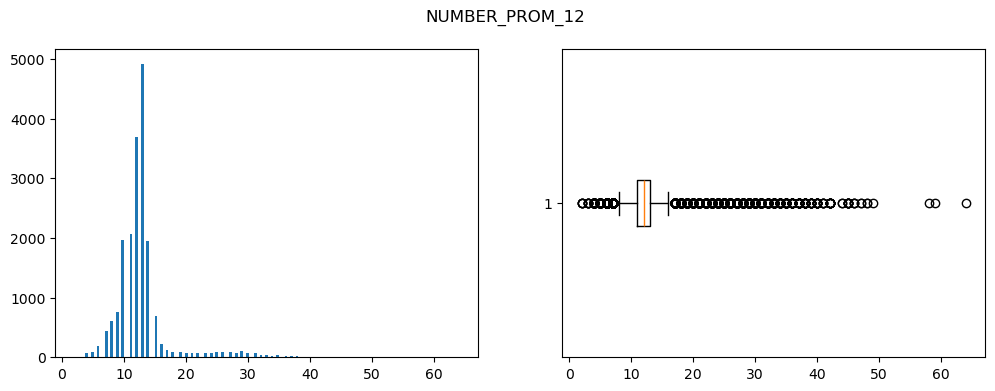

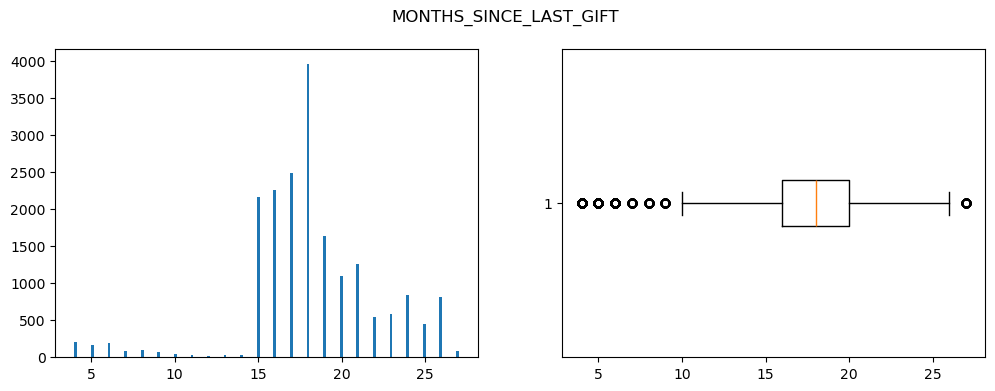

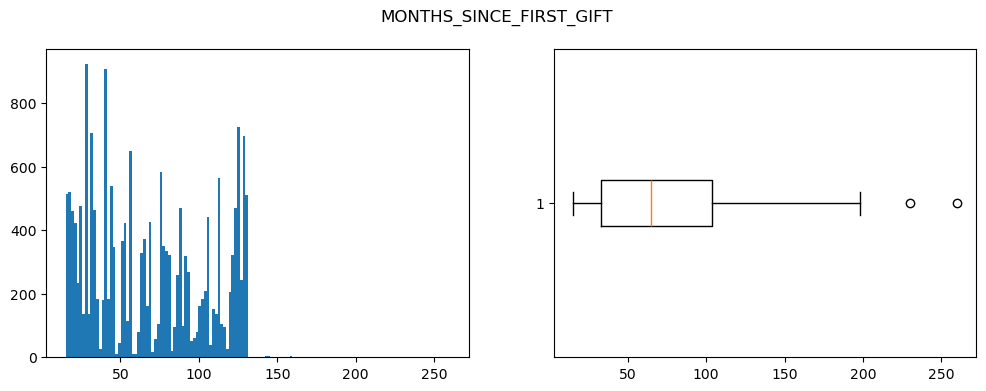

In [44]:
plot_data_numeric(gift_stats)

### Comparing Target Groups

Again, I've plotted the target comaprisons with the outliers removed in order to make the graphs more readable. The averages however are still the full data set, so we can compare those across groups.

Once again, nothing is jumping out as extremely different although there does appear to be a bit more varaition across target groups. On average it appears that target group 1 have been donors for longer and have given more overall, but that they tend to give smaller gifts more frequently, while group 0 tends to give gifts less frequently but in slightly larger amounts. This distribution though still makes me question how well we will be able to get a model to preform since they appear very similar. 

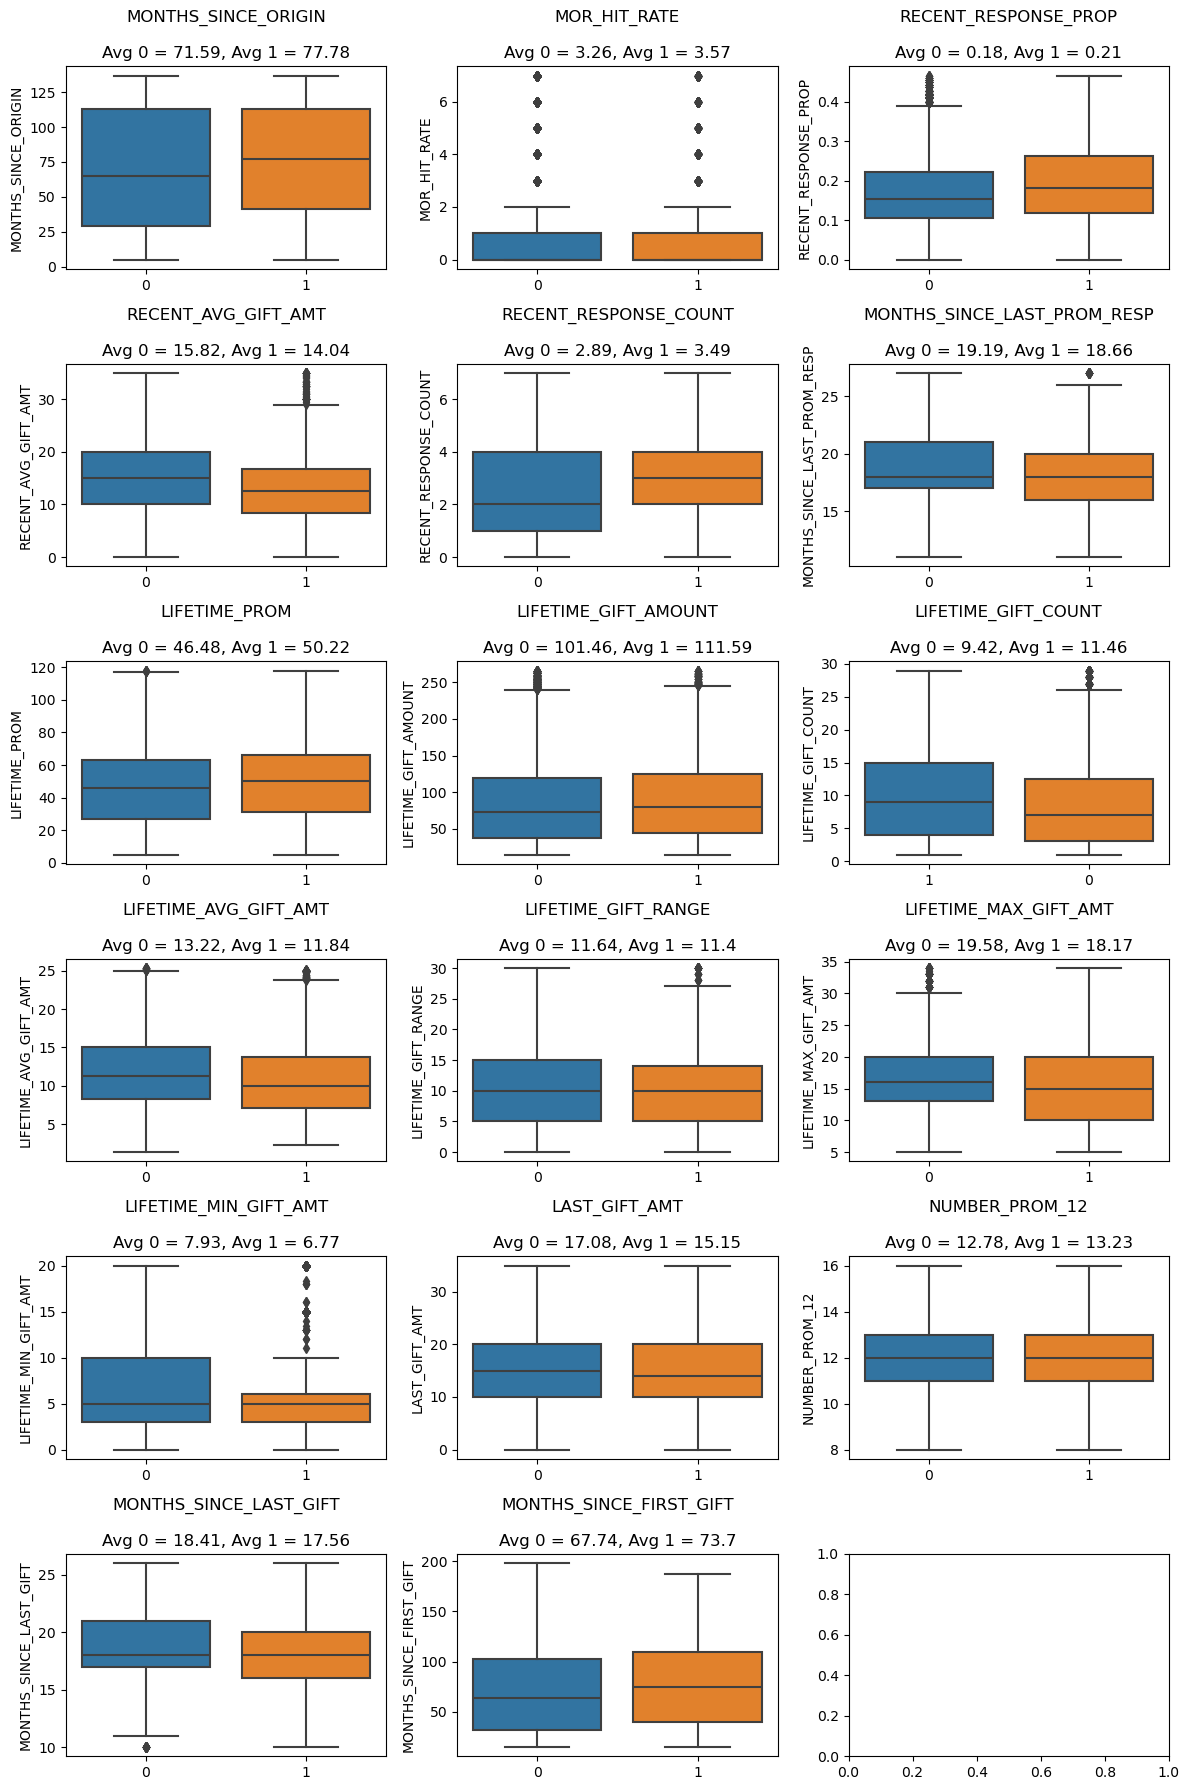

In [45]:
fig, axs = plt.subplots(6, 3, figsize = (12, 18))

plot_data_target(gift_stats, axs)

# Solution Development

## Preparing Data

To prepare my data for model selection, I'm going to do a few things.

1) Scale the data. While not strictly necessary for tree based models, it doesn't hurt and it will be useful if I want to throw in any other model tests. 
2) I will dummy encode the categorical columns in the data.
3) I will split my data into features and target and then into train/test sets.

In [46]:
# Creating copy of donors df to retain original data for comparison if needed
model_df = donors.copy()

# Scaling data - Because so many of my values are positive integers (age, months, etc.) I decided to use minmax scaler to maintain that characteristic. 
scaler = MinMaxScaler()
num_cols = model_df.select_dtypes(include='number').columns
model_df[num_cols] = scaler.fit_transform(X = model_df[num_cols])

# Since I changed the target to string earlier for the plots, I need to convert it back to an int and category here. 
model_df['TARGET_B'] = model_df['TARGET_B'].astype('int64')

# Split into X and y
X = model_df.drop(columns='TARGET_B').copy()
y = model_df['TARGET_B'].copy()

# Convert categorical to dummy vectors
X = pd.get_dummies(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rs)


## Correcting Imbalance

Because my data is so imbalanced, I want to also test whether adjusting my data to correct this imbalance will improve model performance. Because I know that any future donor list will still have this imbalance, I will only adjust the training set, and then test on the imbalanced data to see if the model suffers when trying to predict on imbalance.

In [47]:
undersample = RandomUnderSampler(sampling_strategy='majority', random_state= rs)
X_trainB, y_trainB = undersample.fit_resample(X_train, y_train)

y_trainB.value_counts()

TARGET_B
0    3854
1    3854
Name: count, dtype: int64

## Model Selection

As noted above, due the nature of the data, I am going focus on tree models which will be robust to the abnormalities present. I have chosen to compare a Decision Tree, a Random Forest, and a XGBoost model.

In [48]:
# Instantiate models

dec_tree = DecisionTreeClassifier(random_state= rs)
forest = RandomForestClassifier(random_state= rs)
xgb = XGBClassifier(random_state= rs)


models = [dec_tree, forest, xgb]

### Model Comparison

To do an initial comparison of the models, I used cross_validate to produce an average score for each model with no hypertuning. I included scoring for Accuracy, Precision, Recall, F1, and the ROC score to see if any model was outpreforming the other models on all metrics.

For the imbalanced model, accuracy is never going to be useful, because a 75% accuracy could be achieved just by guessing 'No' every time, it could potentially be more useful as a meausure for the balanced models though. However, any missed donation will be more detrimental to the organization than a phone call made to someone who says no, so I want to prioritize corret predictions of class 1. Therefore, I am going to choose recall as my scoring metric.

After running the two versions of the models, I am getting much higher recall on the balanced dataset, although in both cases the recall score isn't much better than what we'd expect from random guessing. 
Sine in the first model, 25% of the data is class 1, we would expect random guessing to get about 25% of the 1s correct and therefore get about a .25 recall and in the balanced datset we'd expect to get about half of them correct and therefore get about .50 recall, and since our best performing models in each case are about 4% better than guessing, it's hard to say which will perform better on the other data set. 

In [49]:
# Create variables to save individual scores
score_dict_imb = {}
mod_names = ['Tree', 'Forest', 'XGB']

# Create Variables to save average scores
model_scores = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC'])
measures = ('accuracy', 'precision', 'recall', 'f1','roc_auc')

for idx, model in enumerate(models):
    model.fit(X_train, y_train)
    cv_score = cross_validate(estimator= model, X = X_train, y= y_train, scoring= measures, cv= 5)
    scores = []
    name = mod_names[idx] + ' (Imbalanced)'
    score_dict_imb[name] = cv_score['test_recall']
    for m in measures:
        name = 'test_' + str(m)
        score = cv_score[name].mean()
        scores.append(score)
    model_scores.loc[len(model_scores)] = [str(model), scores[0], scores[1], scores[2], scores[3], scores[4]]

model_scores

,Model,Accuracy,Precision,Recall,F1,ROC
0,DecisionTreeClassifier(random_state=7284),0.634999,0.288501,0.307992,0.297814,0.526424
1,RandomForestClassifier(random_state=7284),0.745204,0.434091,0.043329,0.078736,0.591719
2,"XGBClassifier(base_score=None, booster=None, c...",0.730392,0.383175,0.113910,0.175163,0.572094


In [50]:
# Create varaibles to store average scores
score_dict_bal = {}
model_scores = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC'])
measures = ('accuracy', 'precision', 'recall', 'f1','roc_auc')


for idx, model in enumerate(models):
    model.fit(X_trainB, y_trainB)
    cv_score = cross_validate(estimator= model, X = X_trainB, y= y_trainB, scoring= measures, cv= 5)
    scores = []
    name = mod_names[idx] + ' (Balanced)'
    score_dict_bal[name] = cv_score['test_recall']
    for m in measures:
        name = 'test_' + str(m)
        score = cv_score[name].mean()
        scores.append(score)
    model_scores.loc[len(model_scores)] = [str(model), scores[0], scores[1], scores[2], scores[3], scores[4]]

model_scores

,Model,Accuracy,Precision,Recall,F1,ROC
0,DecisionTreeClassifier(random_state=7284),0.527246,0.527789,0.516613,0.522094,0.527248
1,RandomForestClassifier(random_state=7284),0.571355,0.575624,0.542544,0.558351,0.594482
2,"XGBClassifier(base_score=None, booster=None, c...",0.540476,0.541109,0.533989,0.537400,0.557222


In [51]:
# Compare varaition in scores

print(score_dict_bal['XGB (Balanced)'].std())

print(score_dict_bal['Forest (Balanced)'].std())

0.014691450986155288
0.02494525119787619


Comparing the runs, in general the balanced dataset provided much more consistent results across the three models, but models fluctuated slightly more with resepct to each run. While the forest model did end up getting one of the highest scores, it also fluctuated more than the XGBoost model. Because both models got very similar scores, and the XGBoost model seemed to be slightly more consistent, I am going to use the XGBoost model trained on the balanced dataset as my final model. 

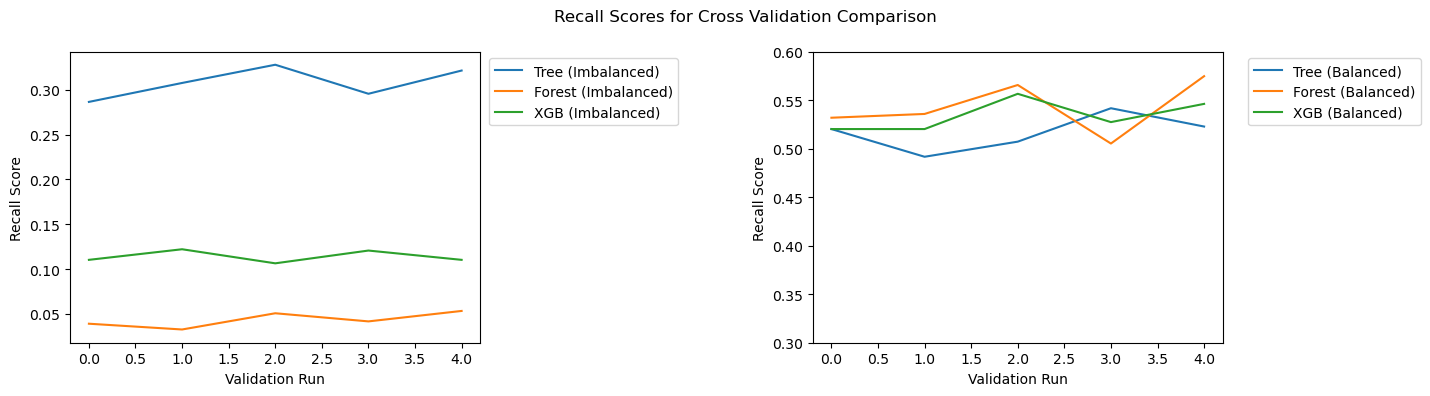

In [52]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 4))

for key, values in score_dict_imb.items():
    ax1.plot(values, label = key)

for key, values in score_dict_bal.items():
    ax2.plot(values, label = key)

ax1.legend(loc= 'upper right', bbox_to_anchor = (1.5, 1))
ax2.legend(loc= 'upper right', bbox_to_anchor = (1.5, 1))

ax2.set_yticks(np.arange(.30, .65, .05))

for ax in [ax1, ax2]:
    ax.set_xlabel('Validation Run')
    ax.set_ylabel('Recall Score')

fig.suptitle('Recall Scores for Cross Validation Comparison')

plt.tight_layout()
plt.show()

## Model Tuning

I chose to use RandomizedSearchCV in order to test a variety of hyperparameters and see if I could improve the model. While I was able to gain a fractional improvement, overall I'm still getting about the same recall as the non-tuned model. But we'll move forward and see how it preforms on the test data. 

Note: final model saved and included in zip file

In [53]:
# params = {
#     'n_estimators' : np.arange(10, 1001, 10),
#     'max_depth': np.arange(1, 6, 1),
#     'learning_rate': [.0001, .001, .01, .1],
#     'reg_alpha': [0, .25, .5, .75, 1],
#     'reg_lambda': [0, .25, .5, .75, 1]
# }

# # search_cv = GridSearchCV(estimator= dec_tree, param_grid= params, verbose= 5, scoring='recall')

# search_cv = RandomizedSearchCV(estimator= xgb, param_distributions= params, scoring= 'recall', n_jobs= 13, verbose= 5, cv= 5, n_iter= 100, random_state= rs, error_score= 'raise')

# search_cv.fit(X_trainB, y_trainB)

# search_cv.best_score_

In [54]:
# Save model to avoid rerunning GridSearch

# pickle.dump(search_cv, open('donor_prediction_searchCVmodel.sav', 'wb'))

# Reload model as needed

search_cv = pickle.load(open('donor_prediction_searchCVmodel.sav', 'rb'))

### Model Description

The final XGBoost model contained 500 trees, each with a depth of 5, and a lerning rate of .1. The regularization parameters were lambda: 0.5 and alpha: 1

In [55]:
search_cv.best_params_

{'reg_lambda': 0.5,
 'reg_alpha': 1,
 'n_estimators': 500,
 'max_depth': 5,
 'learning_rate': 0.1}

## Model Evaluation

As noted earlier, a model that guesses randomly should produce a recall score roughly equivalent to the percentage of class 1 observations in the data. My model trained on data that is equally balanced is performing at about .54 recall, slightly better than random. So if it is actually just a random guessing model, using the model on the unbalanced testing data should produce about .25 recall score. 

However after measuring the predictions on the test set, I'm actually getting a better recall of about .55, this means my model is correctly predicting over half of the potential donors. Missing 45% of donations is obviously not an acceptable trade off for the time gained, so I would not recommend putting this model into production as a way to reduce the phone call list, but it could potentially still be used to prioritize calls in order to reach the most likely donors first. 

Of note, this model's accuracy is pretty terrible because I did not penalize incorrectly predicting 0s as 1s. 

In [56]:
preds = search_cv.best_estimator_.predict(X_test)

In [57]:
test_recall = recall_score(y_test, preds)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)


print('Recall on test set: ', test_recall, '\nF1 on test set: ', test_f1, '\nAccuracy on test set: ',  test_acc)

Recall on test set:  0.5505263157894736 
F1 on test set:  0.3862629246676514 
Accuracy on test set:  0.5662839248434238


In [58]:
num = len(y_test[(y_test == preds) & (y_test) == 1])
num2 = len(y_test[y_test == 1])
pct = round((num/num2)*100, 2)

num_calls = len(preds[preds == 1])
pct_calls = round(num_calls/len(y_test)*100, 2)

print(f'Based on these findings, if we were to use this algorithim in future fundraising\
 campaigns, fundraisers would only make {pct_calls}% of the number of calls, but would also miss {(100-pct)}% of donations')

Based on these findings, if we were to use this algorithim in future fundraising campaigns, fundraisers would only make 45.88% of the number of calls, but would also miss 44.95% of donations


### Feature Importance

Feature importance for XGBoost models is calculated in several different ways. Gain is calculated for each tree by how much that feature reduces the impurity. It is then averaged across all of the trees to produce a single relative importance factor for each feature. This is going to be the best measure of how influential a given factor is, so I will look at this metric to evaluate features.

Looking at the relative importance, some of the features that I visually identified as being more differentiated across target classes have bubbled to the top, such as last gift amount and time since last gift. However, none of the features seem to be especially influential compared to the others and all of them have relatively low importance scores. This aligns with what I visually assessed which was that the two groups are very similar across all metrics, and so there isn't any one specific feature that could be used to identify a donor. 

In [59]:
boost = search_cv.best_estimator_

imp = boost.get_booster().get_score(importance_type = 'gain')

feat_imp = pd.DataFrame.from_dict(imp, orient= 'index')
feat_imp.reset_index(inplace= True)
feat_imp.columns = ['Features', 'Gain']
feat_imp.sort_values(by= 'Gain', inplace=True, ascending= False)

feat_imp

,Features,Gain
18,LAST_GIFT_AMT,3.357180
20,MONTHS_SINCE_LAST_GIFT,2.536280
16,LIFETIME_MAX_GIFT_AMT,2.380089
23,URBANICITY_R,2.301686
26,URBANICITY_U,2.216971
7,RECENT_RESPONSE_PROP,2.205863
9,RECENT_RESPONSE_COUNT,2.178290
13,LIFETIME_GIFT_COUNT,2.169452
14,LIFETIME_AVG_GIFT_AMT,2.153262
21,MONTHS_SINCE_FIRST_GIFT,2.146869


# Conclusion

By balanicng the data, I was able to produce a model that performed fairly well given the dataset and was able to correctly predict just over half of donors who said yes during the last campaign on an unbalanced testing set. However, it's very important that no donors get missed so this model is not going to be sucessful in limiting the number of calls that the team would need to make, although it could help prioritize phone calls.

Based on the visualizations and the relative similartiy of feature importance, I suspect that these donors are just too similar of a population to be able to do much in the way of differntiating them. Because the list is people who have already chosen to give to the organization at least once, the population is likley already self-sorted so the chances of them donating are relatively similar. It's possible that another model, for instance a neural net, might be able to identify more complex relationships than this model although I suspect it would still not perform exceptionally. 

I don't know that additional attempts to predict from this dataset would be particularly useful, but additional areas of study could include looking at first time contacts and whether they donate or not, comparing donations across multiple campagins, or trying to determine if there is a pattern to the size of the gift. 

# Images for Presentation

In [60]:
donors.columns

Index(['TARGET_B', 'MONTHS_SINCE_ORIGIN', 'DONOR_AGE', 'URBANICITY',
       'DONOR_GENDER', 'PUBLISHED_PHONE', 'MOR_HIT_RATE', 'MEDIAN_HOME_VALUE',
       'MEDIAN_HOUSEHOLD_INCOME', 'PCT_OWNER_OCCUPIED', 'PER_CAPITA_INCOME',
       'RECENT_RESPONSE_PROP', 'RECENT_AVG_GIFT_AMT', 'RECENT_RESPONSE_COUNT',
       'MONTHS_SINCE_LAST_PROM_RESP', 'LIFETIME_PROM', 'LIFETIME_GIFT_AMOUNT',
       'LIFETIME_GIFT_COUNT', 'LIFETIME_AVG_GIFT_AMT', 'LIFETIME_GIFT_RANGE',
       'LIFETIME_MAX_GIFT_AMT', 'LIFETIME_MIN_GIFT_AMT', 'LAST_GIFT_AMT',
       'NUMBER_PROM_12', 'MONTHS_SINCE_LAST_GIFT', 'MONTHS_SINCE_FIRST_GIFT'],
      dtype='object')

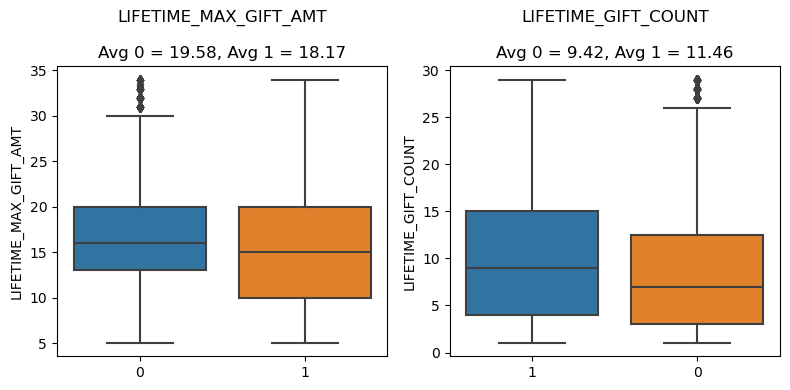

In [61]:
fig, axs = plt.subplots(1, 2, figsize= (8,4))

targs = ['LIFETIME_MAX_GIFT_AMT', 'LIFETIME_GIFT_COUNT']

plot_data_target(targs, axs)